# Einsendeaufgabe 3: Numba (100 Punkte)

In diesem Abschnitt möchten wir unsere Applikationen mit Numba beschleunigen.

## Mandelbrot-Set (10 Punkte)

Wir beginnen mit einem klassischen Beispiel für Parallelisierung: dem Mandelbrot-Set.

Die Mandelbrot-Menge wird durch die Gleichung $z_{n+1} = z_n^2 + c$ beschrieben. In dieser Gleichung sind $c$ und $z$ komplexe Zahlen, und $n$ ist Null oder eine positive ganze Zahl. Ausgehend von $z_0=0$, gehört $c$ zur Mandelbrot-Menge, wenn der Absolutwert von $z_n$ niemals größer als eine bestimmte Zahl wird (diese Zahl ist abhängig von $c$), egal wie groß $n$ wird.

Das bedeutet, eine komplexe Zahl $c$ ist ein Element der Mandelbrotmenge, wenn die Beträge der mit diesem $c$ berechneten $z_{n}$ nicht unbegrenzt wachsen, unabhängig davon, wie groß $n$ wird. Es lässt sich leicht zeigen, dass der Betrag von $z_{n}$ unbegrenzt wächst, sobald ein $z_{n}$ mit $|z_{n}|>2$ auftritt.

Bei der Berechnung des Mandelbrot-Sets legt man oft eine obere Grenze für die maximalen Iterationen fest, um zu testen, ob diese überschritten wird.

Ein einfacher Algorithmus zur Bestimmung, ob ein Wert zum Mandelbrot-Set gehört, sieht folgendermaßen aus:

In [ ]:
import numba
import numpy as np


def escape_time(p, maxiter):
    """Perform the Mandelbrot iteration until it's clear that p diverges
    or the maximum number of iterations has been reached.

    Parameters
    ----------
    p: complex
        point in the complex plane

    maxiter: int
        maximum number of iterations to perform before p is considered in
        the Mandelbrot set.

    Bleibt die Folge mit dieser Startzahl p innerhalb eines stabilen Bereichs?
    wenn ja, gibt sie maxiter (400) zurück (die maximale Anzahl an Iterationen wurde 
    durchlaufen, ohne dass |z| > 2 wurde)

    Wie lange ein Punkt im komplexen Zahlenraum "stabil" bleibt, bevor die Folge „explodiert“.
    Wenn die maximale Iteration (maxiter) erreicht wurde: Die Zahl liegt wahrscheinlich in der 
    Mandelbrot-Menge.

    """
    z = 0j # Startwert der Folge ist 0 (als komplexe Zahl)
    for i in range(maxiter): # Schleife mit maximaler Länge maxiter
        z = z**2 + p # Berechnet das nächste Glied der Folge
        if abs(z) > 2: # Wenn der Betrag von z größer als 2 wird ...
            return i # ... dann "entweicht" die Folge => p gehört NICHT zur Mandelbrot-Menge
    return maxiter # Wenn die Folge maxiter Durchläufe überlebt, ohne zu entweichen => p ist wahrscheinlich in der Menge


a = np.array([0.2 + 0.2j])  # komplexe Zahl als NumPy-Array
escape_time(a, 400) # Problemchen: Die Funktion escape_time erwartet eine einzelne komplexe Zahl, kein Array von komplexen Zahlen!

Die Zahl $0.2+0.2j$ liegt also in der Mandelbrot Menge, da wir nach 400 Iterationen noch nicht die Abbruchbedingung erfüllen.  Allerdings ist es mühsam, jede Zahl einzeln zu testen. Wir erstellen also ein 2-D Feld mit vielen Komplexen Zahlen $|z|<2$: 

In [ ]:
real_param = (-1.5, 1.1, 1500) # Tupel mit drei Werten: (Start, Stop, Anzahl Schritte) für den realen Teil der komplexen Zahl
imag_param = (-1.5j, 1.1j, 1500) # Tupel mit drei Werten: (Start, Stop, Anzahl Schritte) für den imaginären Teil der komplexen Zahl

# Von -1.5 bis 1.1, in 1500 Schritten (für die x-Achse bzw. den Realteil der komplexen Zahlen)
# Von -1.5j bis 1.1j, auch in 1500 Schritten (für die y-Achse bzw. den Imaginärteil)
# z. B. p.linspace(*(-1.5, 1.1, 1500)) wird zu np.linspace(-1.5, 1.1, 1500). 
# Der Stern ist ist ein "Unpacking Operator" in Python.
XX, YY = np.meshgrid(np.linspace(*real_param), np.linspace(*imag_param))

# Erzeugt ein 2D-Feld komplexer Zahlen aus den Gitterpunkten:
# XX enthält die Realteile, YY die Imaginärteile → ergibt die komplexen Zahlen c = x + iy
P = XX + YY

<!-- BEGIN QUESTION -->

**Aufgabe:**  
- Vektorisieren Sie die Funktion mit `np.vectorize`
- Vektorisieren Sie die Funktion mit `numba.vectorize`
- Testen Sie, ob der Parallel-Parameter funktioniert und ob er Performance-Vorteile bringt
- Vergleichen Sie die Laufzeit der drei Versionen und stellen Sie den Vergleich graphisch dar

_Points:_ 7

## Vektorisieren mit `np.vectorize` und `numba.vectorize` (ohne und mit dem Parallel-Parameter) sowie Performance-Vergleiche

In dieser Aufgabe beschäftigen wir uns mit der Berechnung der Mandelbrot-Menge – einem klassischen Beispiel aus der Fraktal-Geometrie. Dabei nutzen wir das sogenannte *Escape-Time-Verfahren*, das für jeden Punkt in der komplexen Zahlenebene bestimmt, ob er zur Mandelbrot-Menge gehört. Diese Berechnung ist sehr rechenintensiv, besonders bei hoher Auflösung – ideal also, um verschiedene Optimierungstechniken zu untersuchen.

Ein zentrales Ziel ist die **Vektorisierung** der Escape-Time-Funktion. In diesem Kontext bedeutet *Vektorisieren*, dass eine Funktion, die ursprünglich für einen einzelnen Wert definiert ist (hier: eine komplexe Zahl), so umgeschrieben oder umgewandelt wird, dass sie effizient auf ganze Arrays von Werten gleichzeitig angewendet werden kann. Dabei wird der Code so umgestaltet, dass er intern Schleifen vermeidet oder sie automatisch durch optimierte Backend-Implementierungen ersetzt. Das reduziert typischerweise den Overhead expliziter Python-Schleifen und verbessert die Performance – manchmal dramatisch.

Wir betrachten drei konkrete Ansätze der Vektorisierung:

1. **`np.vectorize`**: Diese Methode stellt eine einfache Möglichkeit dar, Funktionen auf NumPy-Arrays anzuwenden. Technisch gesehen ist dies jedoch lediglich syntaktischer Zucker – sie bietet keine echten Geschwindigkeitsvorteile, da intern weiterhin eine Python-Schleife ausgeführt wird.

2. **`numba.vectorize`**: Diese Variante kompiliert die Funktion Just-in-Time (JIT) zu Maschinencode. Das kann bereits signifikante Performance-Gewinne bringen, insbesondere bei numerischen Berechnungen.

3. **`numba.vectorize(..., target='parallel')`**: Zusätzlich zur Kompilierung versucht diese Option, die Berechnungen auf mehrere CPU-Kerne zu verteilen. Damit lässt sich bei großen Arrays und ausreichend Rechenkernen ein weiterer Geschwindigkeitsvorteil erzielen – sofern der Overhead der Parallelisierung nicht überwiegt.

Wir messen für alle drei Varianten die Ausführungszeit mit `timeit`, vergleichen die Ergebnisse und die Unterschiede. Ziel ist es, ein Gespür dafür zu bekommen, wie effektiv verschiedene Formen der Vektorisierung in der Praxis sind – und wann sich der Einsatz von `Numba` wirklich lohnt.


Zeit für np.vectorize: 10.9214 Sekunden
Zeit für numba.vectorize: 0.9113 Sekunden
Zeit für numba.vectorize (parallel): 0.9654 Sekunden


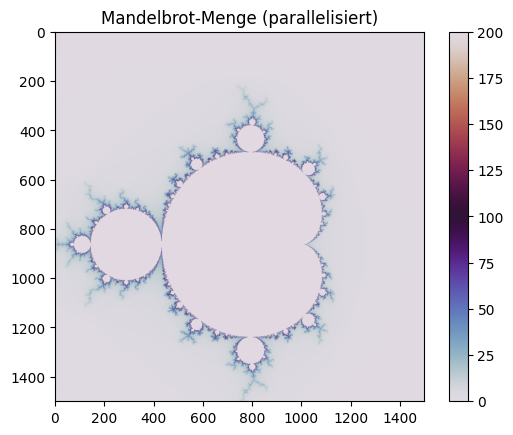

In [9]:
import numba                     # Für Performance-Optimierung durch JIT-Kompilierung
import numpy as np               # Für numerische Operationen und Arrays
import timeit                    # Zum Messen der Ausführungszeit
import matplotlib.pyplot as plt  # Zum Visualisieren der Mandelbrot-Menge

# -------------------------------------------------------------------
# ESCAPE-TIME-FUNKTION (Skalare Version ohne Beschleunigung)
# Diese Funktion prüft für einen komplexen Punkt p, ob er zur Mandelbrot-Menge gehört.
# Dafür wird wiederholt die Formel z = z² + p berechnet. Wenn der Betrag von z > 2 wird,
# verlässt die Folge die Menge. Die Anzahl der benötigten Schritte nennt man "Escape-Time".
# -------------------------------------------------------------------
def escape_time(p, maxiter):
    z = 0j  # Startwert z = 0 (komplexe Zahl 0 + 0j)
    for i in range(maxiter):
        z = z*z + p     # Iterationsformel
        if abs(z) > 2:  # Wenn Betrag > 2, verlässt die Folge die Menge
            return i    # Anzahl der benötigten Schritte wird zurückgegeben
    return maxiter      # Wenn nie > 2, gehört p zur Mandelbrot-Menge

# -------------------------------------------------------------------
# VARIANTE 1: np.vectorize (bequem, aber langsam)
# Diese Methode sieht vektoriell aus, ist aber eigentlich eine Schleifenverpackung.
# Ideal für Verständnis, nicht für Performance.
# -------------------------------------------------------------------
def mandelbrot_set_np_vectorized(P, maxiter):
    # np.vectorize(...) ist eine bequeme Methode, um eine normale (skalare) Funktion
    # (wie escape_time) auf ganze NumPy-Arrays anzuwenden.
    vectorized_escape_time = np.vectorize(escape_time)
    
    # vectorized_escape_time ist jetzt eine Funktion, die intern über jedes einzelne Element
    # von P iteriert und escape_time darauf anwendet – man kann sie wie eine Array-Funktion verwenden.
    
    # Wir wenden die erzeugte vectorized_escape_time-Funktion auf das gesamte 2D-Array P an
    # und geben das Ergebnis zurück (ein Array mit Iterationszahlen).
    return vectorized_escape_time(P, maxiter) # Gibt ein 2D-Array zurück, das für jeden Punkt in P die Escape-Time enthält.
                                               # Beispiel: Wenn P = [[0+0j, 0+1j], [1+0j, 1+1j]], dann könnte die Rückgabe sein:
                                               # [[200, 12],
                                               #  [35, 200]]
                                               # (je nachdem, ob die Punkte zur Mandelbrot-Menge gehören oder wie schnell sie entkommen)

# -------------------------------------------------------------------
# VARIANTE 2: numba.vectorize (mit JIT-Kompilierung)
# Diese Variante verwendet numba.vectorize, um die Escape-Time-Funktion
# automatisch zu kompilieren – also in schnellen Maschinencode umzuwandeln.
# Das geschieht über sogenanntes "Just-In-Time"-Kompilieren (JIT).
# Dadurch läuft der Code viel schneller als in normalem Python.
# -------------------------------------------------------------------

@numba.vectorize(['int32(complex128, int32)'])  # Dekorator von numba: Sagt numba, dass die Funktion für komplexe Zahlen (p) und int (maxiter) verwendet wird und ein int32 zurückgibt.
def escape_time_numba(p, maxiter):
    z = 0j  # Startwert der Folge ist 0 (komplexe Zahl)
    for i in range(maxiter):  # Wiederhole die Berechnung maxiter-mal (z. B. 200 Iterationen)
        z = z*z + p  # Mandelbrot-Iteration: z_{n+1} = z_n² + p
        if abs(z) > 2:  # Wenn der Betrag von z größer als 2 wird, ist der Punkt nicht in der Mandelbrot-Menge
            return i  # Gib die Anzahl der Iterationen zurück, bis das passiert ist
    return maxiter  # Wenn z nie > 2 wurde, dann ist der Punkt vermutlich in der Menge → gib maxiter zurück

# -------------------------------------------------------------------
# Die folgende Funktion sieht so aus wie bei np.vectorize,
# aber sie ruft die JIT-kompilierte Version auf.
# Das bedeutet: sehr viel bessere Performance bei großen Datenmengen.
# -------------------------------------------------------------------
def mandelbrot_set_numba_vectorized(P, maxiter):
    return escape_time_numba(P, maxiter)  # Wende escape_time_numba auf jedes Element im Array P an.
                                          # Das funktioniert, weil numba.vectorize intern selbst Vektorisierung übernimmt.
                                          # Beispiel-Rückgabe:
                                          # Wenn P ein 2D-Array komplexer Zahlen ist, kommt ein gleich großes 2D-Array mit Iterationszahlen zurück.

# -------------------------------------------------------------------
# VARIANTE 3: numba.vectorize mit Parallelisierung
# Diese Variante ist im Prinzip identisch zu Variante 2,
# nutzt aber zusätzlich Parallelisierung durch mehrere CPU-Kerne.
# Das geschieht durch das Argument target='parallel' im numba-Dekorator.
# Besonders bei großen Arrays (z. B. hochaufgelöste Mandelbrot-Bilder)
# bringt das deutliche Performance-Vorteile.
# -------------------------------------------------------------------

@numba.vectorize(['int32(complex128, int32)'], target='parallel')
# Der numba-Dekorator @vectorize macht die Funktion escape_time_numba_par automatisch vektorisierbar.
# Die Signatur 'int32(complex128, int32)' bedeutet:
#   - Eingabe: ein komplexer Wert (p) und ein ganzzahliger Wert (maxiter)
#   - Ausgabe: ein int32 (die Anzahl der Iterationen, bis der Punkt "entkommt")
# Das Besondere hier: Mit target='parallel' wird numba angewiesen,
# die Berechnungen parallel auf mehreren CPU-Kernen auszuführen.

def escape_time_numba_par(p, maxiter):
    z = 0j  # Starte mit z = 0 (komplexe Zahl), wie in der Mandelbrot-Iteration üblich
    for i in range(maxiter):  # Bis zur maximalen Anzahl an Iterationen (z. B. 200)
        z = z*z + p  # Iterationsregel für die Mandelbrot-Menge: z_{n+1} = z_n² + p
        if abs(z) > 2:  # Wenn der Betrag von z größer als 2 wird, entweicht die Folge
            return i  # Dann ist p nicht in der Mandelbrot-Menge → gib die Anzahl der Iterationen zurück
    return maxiter  # Wenn der Punkt die Grenze nie überschreitet → vermutlich Teil der Mandelbrot-Menge

# -------------------------------------------------------------------
# Diese Funktion wendet escape_time_numba_par auf ein gesamtes Array P an.
# P ist ein 2D-Array komplexer Zahlen, das z. B. aus einem linspace-Gitter erstellt wurde.
# Die Funktion gibt ein 2D-Array mit Iterationszahlen zurück – z. B. zum Plotten mit plt.imshow.
# Der Unterschied zu Variante 2: Hier läuft das Ganze parallelisiert und damit schneller.
# -------------------------------------------------------------------
def mandelbrot_set_numba_vectorized_par(P, maxiter):
    return escape_time_numba_par(P, maxiter)  # Das ist wie ein „broadcasting“ auf das gesamte Array P.
                                              # Beispiel:
                                              # Wenn P z. B. ein 1500x1500-Array komplexer Zahlen ist,
                                              # gibt diese Funktion ein 1500x1500-Array mit Iterationszahlen zurück.

# -------------------------------------------------------------------
# ERZEUGUNG DES KOMPLEXEN ZAHLENGITTERS
# Erstelle ein zweidimensionales Gitter (XX + YY) von komplexen Zahlen.
# Jeder Punkt im Gitter stellt einen Punkt im Bild der Mandelbrot-Menge dar.
# -------------------------------------------------------------------
real_param = (-1.5, 1.1, 1500)     # Realteil: Start, Ende, Anzahl Schritte
imag_param = (-1.5j, 1.1j, 1500)   # Imaginärteil: Start, Ende, Anzahl Schritte
XX, YY = np.meshgrid(np.linspace(*real_param), np.linspace(*imag_param))
P = XX + YY  # Kombination zu komplexen Zahlen (z.B. 0.1 + 0.2j)

# -------------------------------------------------------------------
# MAXIMALE ANZAHL DER ITERATIONEN
# Je mehr Iterationen erlaubt sind, desto genauer ist das Ergebnis –
# aber es dauert auch länger. 200 ist ein guter Kompromiss.
# -------------------------------------------------------------------
maxiter = 200

# -------------------------------------------------------------------
# ZEITMESSUNG DER DREI METHODEN
# Wir möchten wissen: Welche Version ist wie schnell?
# Dazu verwenden wir das Modul 'timeit', das sehr genau misst,
# wie lange ein bestimmter Funktionsaufruf dauert.
# In unserem Fall messen wir jeweils die Zeit für genau **einen** Aufruf.
# -------------------------------------------------------------------

# Misst die Zeit (in Sekunden), die die np.vectorize-Version benötigt.
# Diese Version ist meist die langsamste, weil keine echte Optimierung passiert.
time_np_vectorized = timeit.timeit(
    lambda: mandelbrot_set_np_vectorized(P, maxiter),  # Der Funktionsaufruf, den wir messen
    number=1  # Anzahl der Wiederholungen (hier: genau einmal)
)

# Misst die Zeit für die Version mit numba.vectorize (ohne Parallelisierung).
# Durch Just-in-Time-Kompilierung ist sie deutlich schneller als reine Python-Schleifen.
time_numba_vectorized = timeit.timeit(
    lambda: mandelbrot_set_numba_vectorized(P, maxiter),
    number=1
)

# Misst die Zeit für die parallelisierte numba.vectorize-Version.
# Diese ist in der Regel die schnellste, da sie mehrere CPU-Kerne verwendet.
time_numba_vectorized_par = timeit.timeit(
    lambda: mandelbrot_set_numba_vectorized_par(P, maxiter),
    number=1
)

# -------------------------------------------------------------------
# AUSGABE DER LAUFZEITEN
# Jetzt drucken wir die gemessenen Zeiten übersichtlich aus.
# So kann man direkt vergleichen, welche Methode wie schnell war.
# -------------------------------------------------------------------

# Ausgabe der benötigten Zeit für die np.vectorize-Variante.
# Hier sieht man typischerweise die längste Laufzeit.
print(f"Zeit für np.vectorize: {time_np_vectorized:.4f} Sekunden")

# Ausgabe der Laufzeit für numba.vectorize ohne Parallelisierung.
# Deutlich schneller, weil JIT-Kompilierung genutzt wird.
print(f"Zeit für numba.vectorize: {time_numba_vectorized:.4f} Sekunden")

# Ausgabe der Laufzeit für numba.vectorize mit Parallelisierung.
# In der Regel die schnellste Variante, vor allem bei großen Arrays.
print(f"Zeit für numba.vectorize (parallel): {time_numba_vectorized_par:.4f} Sekunden")

# -------------------------------------------------------------------
# VISUALISIERUNG DER MANDELBROT-MENGE
# Jetzt wollen wir das Ergebnis als Bild sehen.
# Dazu berechnen wir erneut die Mandelbrot-Menge (mit der schnellsten Methode)
# und verwenden Matplotlib, um die Escape-Times in Farben darzustellen.
# Jeder Punkt im Bild entspricht einem komplexen Punkt.
# Die Farbe zeigt, wie schnell dieser Punkt aus der Mandelbrot-Menge „entkommt“.
# -------------------------------------------------------------------

# Berechne das Escape-Time-Bild mit der parallelisierten Methode
# → ergibt ein 2D-Array M, das die Iterationszahlen (Escape-Times) enthält
M = mandelbrot_set_numba_vectorized_par(P, maxiter)

# Visualisiere das Array M als Bild
# Jeder Pixel bekommt eine Farbe, je nachdem wie groß die Escape-Time war
# Die Farbkarte 'twilight' sieht für diese Art von Bildern besonders hübsch aus
plt.imshow(M, cmap='twilight')

# Titel des Plots
plt.title("Mandelbrot-Menge (parallelisiert)")

# Zeige eine Farbskala an der Seite – hilfreich, um die Bedeutung der Farben zu erkennen
plt.colorbar()  # Farbskala, die die Escape-Times der Punkte darstellt. 
                # Dunkle Farben (z.B. Blau) stehen für Punkte, die langsam 
                # aus der Mandelbrot-Menge entweichen (d.h. eine hohe Escape-Time haben). 
                # Helle Farben (z.B. Gelb, Weiß) stehen für Punkte, die schnell entweichen 
                # (d.h. eine niedrige Escape-Time haben). Diese Farbskala hilft, die Struktur 
                # der Mandelbrot-Menge und die Geschwindigkeit der Divergenz der Punkte visuell zu verstehen.
                # Die Escape-Time ist die Anzahl der Iterationen, die notwendig sind, 
                # damit der Betrag der komplexen Zahl die Grenze von 2 überschreitet.
                # Ein hoher Wert für die Escape-Time bedeutet, dass der Punkt viele Iterationen 
                # braucht, um die Grenze zu überschreiten, was darauf hinweist, dass der Punkt 
                # langsam aus der Menge "entweicht" und somit länger in der Nähe der Mandelbrot-Menge bleibt.
                # Ein niedriger Wert bedeutet, dass der Punkt schnell die Grenze überschreitet 
                # und somit schneller aus der Menge entweicht.

# Zeige das Fenster mit dem Plot an
plt.show()


<!-- BEGIN QUESTION -->

**Aufgabe:** Vergleichen Sie nun die drei Versionen mit Scalene. Verwenden sie eine Sampling-Rate von $0.0001$

_Points:_ 3

Vergleich der drei Versionen der Mandelbrot-Berechnung mit Scalene

In dieser Aufgabe vergleichen wir die Performance von drei unterschiedlichen Varianten der Berechnung der Mandelbrot-Menge, die wir zuvor implementiert haben. Die Varianten basieren auf unterschiedlichen Methoden, um die Berechnungen zu optimieren:

1. **Version 1: `np.vectorize`** – Eine einfache Methode zur Vektorisierung mit NumPy, die eine skalare Funktion auf ganze Arrays anwendet.
2. **Version 2: `numba.vectorize`** – Eine optimierte Version unter Verwendung von Numba, um den Code mit Just-In-Time (JIT)-Kompilierung zu beschleunigen.
3. **Version 3: `numba.vectorize` mit Parallelisierung** – Diese Version geht noch einen Schritt weiter und nutzt die Parallelisierung mit mehreren CPU-Kernen, um die Berechnungen weiter zu beschleunigen.

Wir verwenden **Scalene**, ein leistungsstarkes Profiling-Tool, um die CPU- und Speicherperformance jeder Version zu messen und zu vergleichen. 

### Bedeutung der Sampling-Rate von **0.0001**

Die **Sampling-Rate** gibt an, wie häufig Scalene Stichproben der CPU-Nutzung und des Speichers entnimmt, während das Programm ausgeführt wird. Eine Sampling-Rate von **0.0001** bedeutet, dass Scalene bei jedem 10.000. (1 / 0.0001) Zyklus der Ausführung eine Messung der Systemressourcen vornimmt. Dies sorgt für eine detaillierte und präzise Erfassung der Performance, ohne dass zu viele Daten gesammelt werden, was die Analyse verzerren könnte. Eine niedrige Sampling-Rate ermöglicht es, sehr granular zu messen und auch feine Unterschiede zwischen den verschiedenen Varianten zu erkennen.

Mit dieser Sampling-Rate von **0.0001** erhalten wir also eine feine Auflösung der Profildaten, was uns hilft, die effizienteste Berechnungsmethode zu identifizieren und gleichzeitig die Auswirkungen von Optimierungen wie Parallelisierung und JIT-Kompilierung zu beobachten.

Im Folgenden werden wir die drei Versionen mit Scalene profilieren und die Laufzeiten sowie den Ressourcenverbrauch der verschiedenen Methoden analysieren.

In [ ]:
with open("/workspaces/SC_EA1_bis_EA3/mandelbrot_versionen.py", "w") as f:
    f.write("""
import numba
import numpy as np

def escape_time(p, maxiter):
    z = 0j
    for i in range(maxiter):
        z = z*z + p
        if abs(z) > 2:
            return i
    return maxiter

def mandelbrot_set_np_vectorized(P, maxiter):
    vectorized_escape_time = np.vectorize(escape_time)
    return vectorized_escape_time(P, maxiter)

@numba.vectorize(['int32(complex128, int32)'])
def escape_time_numba(p, maxiter):
    z = 0j
    for i in range(maxiter):
        z = z*z + p
        if abs(z) > 2:
            return i
    return maxiter

def mandelbrot_set_numba_vectorized(P, maxiter):
    return escape_time_numba(P, maxiter)

@numba.vectorize(['int32(complex128, int32)'], target='parallel')
def escape_time_numba_par(p, maxiter):
    z = 0j
    for i in range(maxiter):
        z = z*z + p
        if abs(z) > 2:
            return i
    return maxiter

def mandelbrot_set_numba_vectorized_par(P, maxiter):
    return escape_time_numba_par(P, maxiter)

# Gitter erstellen (kleiner für Profiling-Zwecke)
real_param = (-1.5, 1.1, 300)
imag_param = (-1.5j, 1.1j, 300)
XX, YY = np.meshgrid(np.linspace(*real_param), np.linspace(*imag_param))
P = XX + YY
maxiter = 200

# alle drei Varianten EINMAL aufrufen
mandelbrot_set_np_vectorized(P, maxiter)
mandelbrot_set_numba_vectorized(P, maxiter)
mandelbrot_set_numba_vectorized_par(P, maxiter)
""")

!scalene mandelbrot_versionen.py --cpu-sampling-rate 0.0001


<!-- END QUESTION -->

## Springende Bälle, Teil 2 (60 Punkte)
Wir wollen die Simulation mit mehreren Bällen verbessern und optimieren. 

Jetzt werden zusätzlich Kollisionen zwischen den Bällen beachtet.
Dafür wollen wir zunächst berechnen, ob die Bälle in einem Zeitschritt kollidieren. Eine genaue Berechnung ist hier sehr schwer, daher können wir dies nur näherungsweise machen. Wir müssen dazu auch folgende Annahmen machen:

1. Die Bälle haben einen Radius von $r$, alle Bälle sind gleich groß 
2. Der Zeitschritt $\Delta t$ und die Geschwindigkeit $\$v$ der Bälle sind so gewählt, dass ein Ball maximal viermal seinen Radius in einem Zeitschritt zurücklegt, also $v*\Delta t <= 4*r$


Wir berechnen nun in jeden Zeitschritt zunächst 3 zusätzliche Zwischenzeitschritte:

$ c_0 = c_0$

$c_1 = c_0+0.25\Delta t *v$

$c_3 = c_0+0.5\Delta t *v$

$c_4 = c_0+0.75\Delta t * v$

(Der nächste Schritt wäre $\Delta t$, dieser wird aber in der nächsten Iteration beachtet.)


Wir betrachten nun jeweils für 2 Bälle, ob sie sich in einem der Zwischenzeitschritte näher als zweimal dem Radius $r$ kommen. Wenn sie das tun, gibt es eine Kollision.

<!-- BEGIN QUESTION -->

**Aufgabe:** Schreiben Sie eine Funktion, die dies für zwei Bälle testet und zunächst `True` oder `False` zurück gibt. Für die Berechnung des Abstands können sie die Funktion `np.linalg.norm` verwenden.

_Points:_ 10

In [ ]:
def will_collide(c1, v1, c2, v2, r, dt):
    ...

<!-- END QUESTION -->

Um die Geschwindigkeiten der Bälle nach einer Kollision zu berechnen, können wir die Erhaltung des Impulses und die Erhaltung der kinetischen Energie heranziehen, unter der Annahme, dass es sich um eine vollkommen elastische Kollision handelt. Bei einer solchen Kollision bleiben sowohl der Gesamtimpuls als auch die gesamte kinetische Energie des Systems erhalten. Die Berechnungen werden allerdings etwas komplexer, wenn wir Richtungen berücksichtigen.

#### Geschwindigkeiten nach der Kollision

Für zwei Bälle mit Massen $m_1$ und $m_2$, den Anfangsgeschwindigkeiten $v_1$ und $v_2$ und den Endgeschwindigkeiten $v_1'$ und $v_2'$ gelten folgende Gleichungen basierend auf dem Impulserhaltungssatz und der Erhaltung der kinetischen Energie:

1. **Impulserhaltung:**
   $m_1 v_1 + m_2 v_2 = m_1 v_1' + m_2 v_2'$

2. **Erhaltung der kinetischen Energie:**
   $\frac{1}{2} m_1 v_1^2 + \frac{1}{2} m_2 v_2^2 = \frac{1}{2} m_1 {v_1'}^2 + \frac{1}{2} m_2 {v_2'}^2$

Diese Gleichungen müssen vektoriell gelöst werden, da die Geschwindigkeiten Richtungen haben.

Die Lösungen für die Geschwindigkeiten nach der Kollision in zwei Dimensionen unter der Annahme einer vollkommen elastischen Kollision und unter Ignorierung der Rotation der Bälle sind:

$v_1' = v_1 - \frac{2 m_2}{m_1 + m_2} \frac{(v_1 - v_2) \cdot (c_1 - c_2)}{\|c_1 - c_2\|^2} (c_1 - c_2)$

$v_2' = v_2 + \frac{2 m_1}{m_1 + m_2} \frac{(v_1 - v_2) \cdot (c_1 - c_2)}{\|c_1 - c_2\|^2} (c_1 - c_2)$

Hierbei ist $(v_1 - v_2) \cdot (c_1 - c_2)$ das Skalarprodukt der Vektoren $v_1 - v_2$ und $c_1 - c_2$, und $\|c_1 - c_2\|$ ist der Betrag des Vektors $(c_1 - c_2)$, welcher den Abstand zwischen den Zentren der Bälle darstellt.


<!-- BEGIN QUESTION -->

**Aufgabe:** Schreiben Sie eine Funktion, welche die neuen Geschwindigkeiten der Bälle NACH einer Kollision berechnet.  
Sie übergeben der Funktion die folgenden Daten.
- Koordinaten ($c_1, c_2$)
- Geschwindigkeiten ($v_1, v_2$)
- Massen ($m_1, m_2$)

Für die Berechnung des Betrags können Sie wiederum die Funktion `np.linalg.norm` verwenden.

_Points:_ 10

In [ ]:
def collision(c1, c2, v1, v2, m1, m2):
    """Elastischer Stoß zwischen den Bällen 1 und 2."""
    ...
    return v1_new, v2_new


def test_collision(case):
    # Online simulator
    # https://phet.colorado.edu/sims/html/collision-lab/latest/collision-lab_all.html
    if case == "x":
        c1 = np.array([1, 1])
        c2 = np.array([2, 1])
        v1 = np.array([1, 0])
        v2 = np.array([-1, 0])
    if case == "y":
        c1 = np.array([1, 1])
        c2 = np.array([1, 2])
        v1 = np.array([0, 1])
        v2 = np.array([0, -1])
    if case == "diagonal":
        c1 = np.array([1, 1])
        c2 = np.array([2, 2])
        v1 = np.array([1, 1])
        v2 = np.array([0, 0])
    if case == "custom":
        c1 = np.array([1, 1])
        c2 = np.array([2, 3])
        v1 = np.array([1, 1])
        v2 = np.array([0, -1])
    v1_new, v2_new = collision(c1, c2, v1, v2, 1, 1)
    assert np.allclose(np.abs(v2 - v1), np.abs(v2_new - v1_new))
    print(f"{v1=}, {v2=}, {v1_new=}, {v2_new=}")

    # different mass
    v1_new, v2_new = collision(c1, c2, v1, v2, 1, 20)
    assert np.allclose(np.abs(v2 - v1), np.abs(v2_new - v1_new))
    print(f"{v1=}, {v2=}, {v1_new=}, {v2_new=}")


test_collision(case="x")
test_collision(case="y")
test_collision(case="diagonal")
test_collision(case="custom")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Aufgabe:** Nun wollen wir eine Funktion implementieren, die alle möglichen Kollisionen in einem Zeitschritt erfasst und die neuen Geschwindigkeiten der Bälle berechnet – und zwar möglichst effizient. 

Dafür sollten Sie die folgenden Dinge beachten:
1. Es macht nicht für alle Ballpaare sinnvoll alle vier Zwischenzeitschritte zu berechnen. Testen Sie daher zunächst, ob sich zwei Bälle bereits näher als $ 8 \cdot r $ sind.
2. Sie können annehmen, dass sich der Ball bis zum Zwischenschritt, in dem die Kollision berechnet wird, mit der alten Geschwindigkeit bewegt, danach mit der neuen. Implementieren Sie dies entsprechend. Achten Sie auch darauf, dass ein Ball, für den eine Kollision berechnet wurde, im selben Zeitschritt keine vollständige Bewegung für $ \Delta t $ mehr macht.
3. Es kann leicht passieren, dass zwei Bälle, die in einem Zeitschritt kollidieren, es nicht schaffen, sich während des Zeitschritts weit genug aufeinander zu bewegen, sodass sie im folgenden Zeitschritt wieder miteinander kollidieren. Das kann dann dazu führen, dass die Bälle sich umkreisen. Um das zu verhindern, verwenden wir eine Maske (`mask`), die dafür sorgt, dass zwei Bälle nicht in zwei (oder mehr) aufeinanderfolgenden Zeitschritten miteinander kollidieren können.

Anmerkung: Die Situation, dass mehrere Bälle gleichzeitig, in einem Zeitschritt kollidieren, kann hier vereinfacht ignoriert werden.

_Points:_ 10

In [ ]:
def get_all_collisions(c, v, m, r, dt, mask):
    ...

In [ ]:
import numpy as np

# Anfangsbedingungen (Vorschlag)
g = np.array([0, -9.81], dtype=np.float64)
xmax = 1000
ymax = 1000
steps = 2000
dt = xmax * 1e-5
# Anzahl Bälle
N = 20

# Durchmesser Ball
r = xmax * dt
print(r)
rng = np.random.default_rng(seed=123)


# Startpositionen
def init(n=N):
    c = xmax * rng.random((N, 2))
    # Startgeschwindigkeiten, max.
    v = np.array([xmax, ymax]) * rng.random((N, 2))
    # Masse
    m = np.full(N, 0.05)
    mask = np.full((N, N), 0, np.int32)
    return c, v, m, mask

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Aufgabe:** Implementieren Sie nun einen vollständigen Zeitschritt mit Kollisionen. 

_Points:_ 10

In [ ]:
def timestep_with_collisions(c, v, m, dt, g, xmax, ymax, mask):
    """
    Simulate a timestep for multiple balls with collisions.

    Parameters:
        c: ...
        v: ...
        m: Masses
        dt: The duration of a single timestep
        g: Gravitation
        xmax: Box limit in x direction
        ymax: Box limit in y direction
    """
    ...

In [ ]:
c, v, m, mask = init()
timestep_with_collisions(c, v, m, dt, g, xmax, ymax, mask)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Aufgabe:** Animieren Sie die Bewegung der Bälle.

Tipp: Trennen Sie Simulation und Visualisierung und visualisieren Sie z.B. nur jeden 100. Simulationsschritt. 

_Points:_ 5

In [ ]:
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Aufgabe:** Analysieren Sie nun die Simulation mit Scalene. Was hat sich gegenüber der alten Version ohne die Kollisionen verändert? 

_Points:_ 5

_Type your answer here, replacing this text._

In [ ]:
c, v, m, mask = init(10)

In [ ]:
%%scalene --cpu-sampling-rate 0.01
...

In [ ]:
c, v, m, mask = init(300)

In [ ]:
%%scalene --cpu-sampling-rate 0.01
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Aufgabe:** Versuchen Sie Ihren Code (d.h. `timestep_with_collisions`) zu optimieren, damit er besser skaliert.

Vergleichen Sie danach die Ausführungszeiten beider Varianten für 20 Zeitschritte mit $[100, 200,300]$ Bällen.

Stellen Sie den Vergleich graphisch dar.

_Points:_ 10

In [ ]:
## Optimized CODE
import numba


...

In [ ]:
c, v, m, mask = init()
timestep_with_collisions_numba(c, v, m, dt, g, xmax, ymax, mask)

In [ ]:
...

In [ ]:
...

<!-- END QUESTION -->

## Optimierung des Gauß-Verfahrens (30 Punkte)

<!-- BEGIN QUESTION -->

**Aufgabe:** Optimieren Sie die Funktionen `lu_decomposition` und `custom_solve` aus der zweiten Einsendeaufgabe mit Hilfe von Numba.

An welcher Stelle ist die Verwendung von `prange` richtig und sinnvoll? 

Vergleichen Sie die Performance vor und nach der Optimierung für Gleichungssysteme der Größe $256\times 256 $ und $512 \times 512$.

Stellen Sie den Vergleich graphisch dar.

_Points:_ 30

In [ ]:
...

In [ ]:
...

<!-- END QUESTION -->

Führen Sie alle Zellen im Notebook aus und speichern Sie es.  
Danach können Sie mit der folgenden Zelle eine HTML-Datei erstellen.  
Eine mögliche `UserWarning` können Sie ignorieren.  
Bitte geben Sie das Notebook als `.ipynb` und `.html` Datei ab.

In [ ]:
#!jupyter nbconvert --to html EA3.ipynb